# Importing Libraries and Datasets

In [281]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from sklearn import linear_model, feature_selection, metrics, model_selection, datasets
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pypalettes
import warnings
warnings.filterwarnings('ignore')

counties_pol_party = pd.read_csv('counties_pol.csv')

In [282]:
counties_pol_party.shape
counties_pol_party.reset_index(inplace=True)
counties_pol_party = counties_pol_party.drop(columns='index')

In [283]:
# changing fips to str value
counties_pol_party['fips']= counties_pol_party['fips'].astype(str)

## Standardizing Values

In [ ]:
independent_vars = ['income_inequality', 'gender_pay_gap',
       'school_segration_index', 'residential_segregation',
       'school_funding_gap']

dependent_vars = ['hs_diploma_percentage', 'unemployed_percentage', 'population', 'median_income', 'uninsured__percentage', 'premature_death', 'child_poverty_percentage', 'life_expectancy', 'child_mortality', 'high_housing_cost_percentage', 'firearm_fatalities', 'child_care_cost_burden']
vars_to_z = independent_vars + dependent_vars
counties_pol_copy = counties_pol_party.copy()

In [ ]:
# multiplies each percentage column by county polulation to yield total amounts
def calc_z(df, cols):
    for i in df[cols]:
        df[i] = np.abs(stats.zscore(df[i])) 
    return df

In [ ]:
z_counties= calc_z(counties_pol_copy, vars_to_z)

# Variable Selection with Pairwise Mutual Information 

In [284]:
# Initialize a matrix to store mutual information
mutual_info_matrix = np.zeros((len(independent_vars), len(dependent_vars)))

# Calculate mutual information for each independent-dependent variable pair
for i, var1 in enumerate(independent_vars):
    for j, var2 in enumerate(dependent_vars):
        X = counties_pol_party[[var1]]
        y = counties_pol_party[var2]
        mutual_info = mutual_info_regression(X, y)
        mutual_info_matrix[i, j] = mutual_info[0]  # Store the mutual info scalar

# Convert the matrix to a DataFrame for easier viewing
mutual_info_df = pd.DataFrame(mutual_info_matrix, index=independent_vars, columns=dependent_vars)

# Display the mutual information DataFrame
print(mutual_info_df)

                         hs_diploma_percentage  unemployed_percentage  \
income_inequality                     0.109063               0.070164   
gender_pay_gap                        0.047625               0.001964   
school_segration_index                0.025305               0.049013   
residential_segregation               0.045459               0.009547   
school_funding_gap                    0.224891               0.033415   

                         population  median_income  uninsured__percentage  \
income_inequality          0.025471       0.210262               0.070732   
gender_pay_gap             0.070817       0.026531               0.030401   
school_segration_index     0.173604       0.030047               0.005794   
residential_segregation    0.080698       0.021750               0.073243   
school_funding_gap         0.088499       0.249646               0.250012   

                         premature_death  child_poverty_percentage  \
income_inequality           

## Visualizing Pairwise Mutual Information as Heatmap

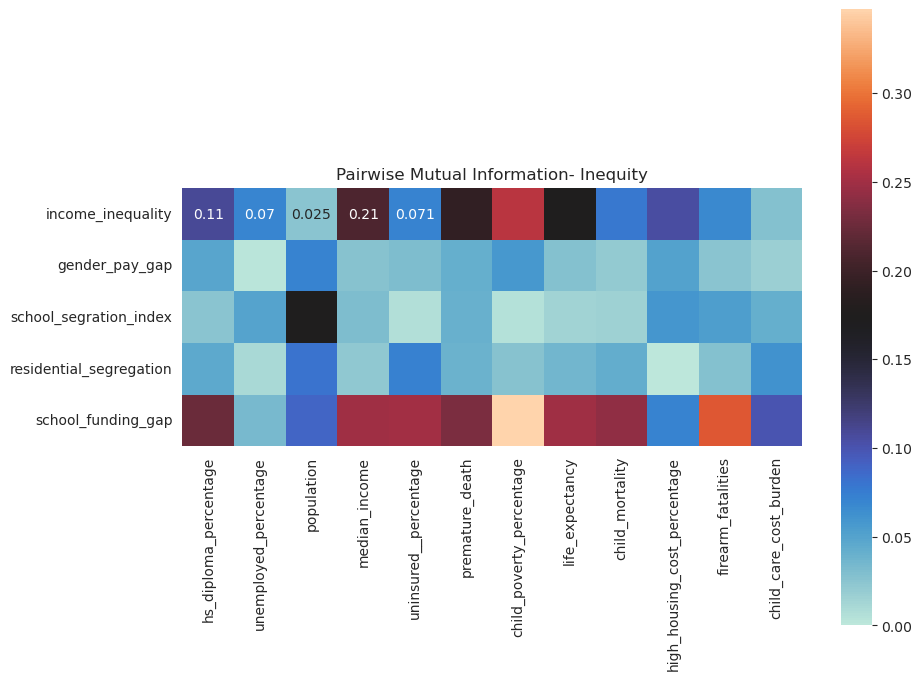

In [285]:
plt.figure(figsize=(10, 8))
sns.heatmap(mutual_info_df, annot=True, cmap='icefire', square=True)
plt.title('Pairwise Mutual Information- Inequity')
plt.show()

# Identifying most 'informative' pairs

In [286]:
top_var_pairs = mutual_info_df.unstack().sort_values(ascending=False).head(12)
print(top_var_pairs)

child_poverty_percentage  school_funding_gap    0.347363
firearm_fatalities        school_funding_gap    0.286136
child_poverty_percentage  income_inequality     0.260594
uninsured__percentage     school_funding_gap    0.250012
median_income             school_funding_gap    0.249646
life_expectancy           school_funding_gap    0.248499
child_mortality           school_funding_gap    0.242613
premature_death           school_funding_gap    0.232733
hs_diploma_percentage     school_funding_gap    0.224891
median_income             income_inequality     0.210262
premature_death           income_inequality     0.192206
life_expectancy           income_inequality     0.174595
dtype: float64


### Selecting most 'informative' variables
- x: 'school_funding_gap', 'income_inequality'
- y: 'child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'

*including political party elected from 2020 general election for additional comparative visualizations*

In [287]:
high_mutual_info_vars = ['state_abbr', 'county', 'fips', 'school_funding_gap', 'child_poverty_percentage', 'income_inequality', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death', 'political_party']
agg_select_subset = counties_pol_party[high_mutual_info_vars]
x_vars= ['school_funding_gap', 'income_inequality']
y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death']

# Descriptive Statistics for Selected Variables

In [ ]:
agg_select_subset.describe().round(2)

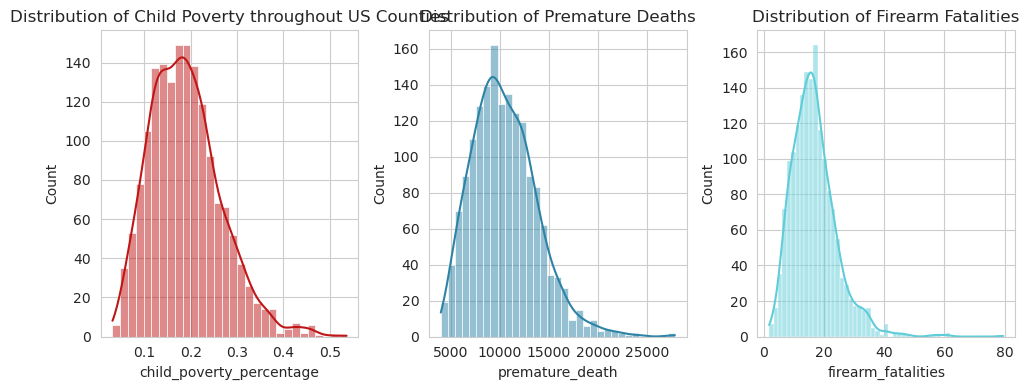

In [288]:

 # Plot the distribution of the target variables
 plt.figure(figsize=(10, 4))
 plt.subplot(1, 3, 1)
 sns.histplot(agg_select_subset['child_poverty_percentage'], kde=True, color='#BF1717')
 plt.title('Distribution of Child Poverty throughout US Counties')
 
 plt.subplot(1, 3, 2)
 sns.histplot(agg_select_subset['premature_death'], kde=True, color='#2D83A6')
 plt.title('Distribution of Premature Deaths')

 plt.subplot(1, 3, 3)
 sns.histplot(agg_select_subset['firearm_fatalities'], kde=True, color='#5FCDD9')
 plt.title('Distribution of Firearm Fatalities')

 plt.tight_layout()
 plt.show()

## Variance 

In [ ]:
agg_select_subset.var(numeric_only=True)

## Correlation 

In [ ]:
corr_matrix = agg_select_subset.corr(method='kendall', numeric_only=True).round(2)
sns.heatmap(corr_matrix, annot=True, cmap='icefire')

### Correlation Pairs

In [ ]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['school_funding_gap']))

In [ ]:
print(agg_select_subset[y_vars].corrwith(agg_select_subset['income_inequality']))

### Covariance

In [ ]:
agg_select_subset.cov(numeric_only=True).round(2)

## Pair Plots

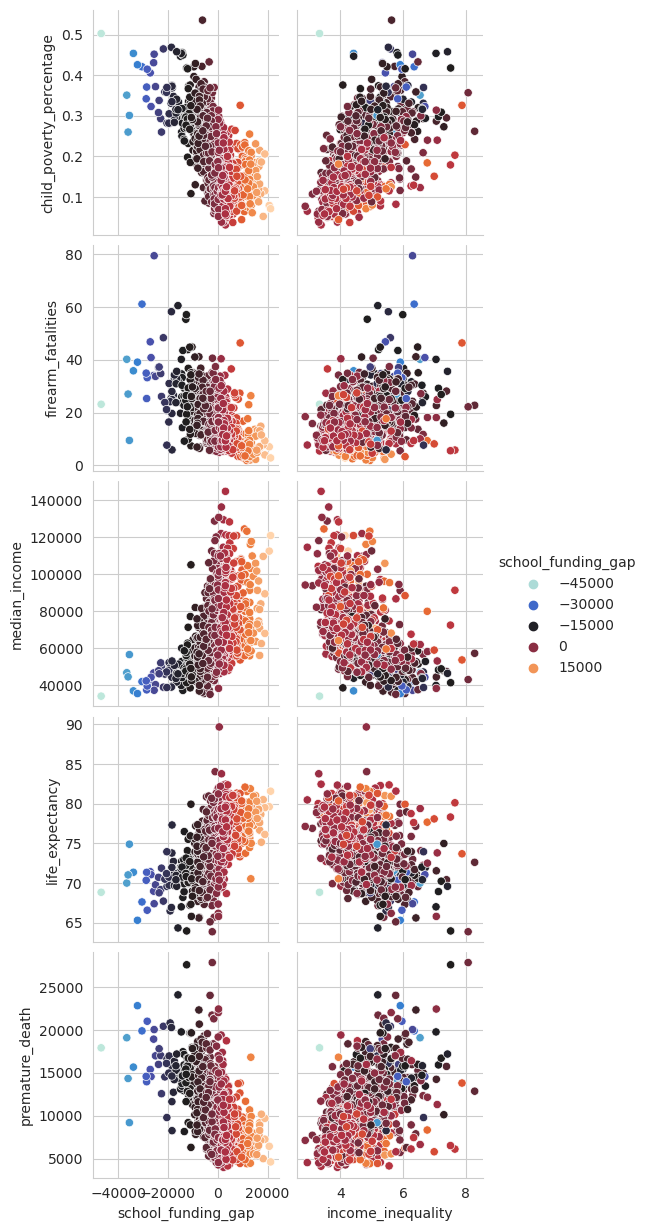

In [289]:
sns.pairplot(agg_select_subset, 
    x_vars= ['school_funding_gap', 'income_inequality'],
    y_vars= ['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death'],
    hue = 'school_funding_gap',
    palette='icefire',
    )     

# Regression: Selecting Best Model 

In [290]:
X = agg_select_subset[['school_funding_gap']]
X_1 = agg_select_subset[['income_inequality']]
Y = agg_select_subset['child_poverty_percentage']
y_1 = agg_select_subset['firearm_fatalities']
y_2 = agg_select_subset['median_income']
y_3 = agg_select_subset['life_expectancy']
y_4 = agg_select_subset['premature_death']

## Linear Regression


In [323]:

lm = LinearRegression()
lm.fit(X, Y)
Yhat=lm.predict(X)
Yhat[0:5]
print(lm.intercept_)
print(lm.coef_)

-0.041458898759302615
[-5.69169899e-06  4.89592128e-02]


## Multi-target- MultiRegressor

In [293]:
x_s = grouped_df[['school_funding_gap', 'income_inequality']]
y_s = grouped_df[['child_poverty_percentage', 'firearm_fatalities', 'median_income' , 'life_expectancy', 'premature_death']]

In [294]:
X, y = x_s, y_s
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [295]:
# Create and train the multi-target regression model (ElasticNet)
multioutput_model = MultiOutputRegressor(
    ElasticNet(alpha=0.5, l1_ratio=0.5), n_jobs=5)
multioutput_model.fit(X_train, y_train)

# Create and train the decision tree regressor model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Create and train the random forest regressor model
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [296]:
# Make predictions
multioutput_pred = multioutput_model.predict(X_test)
tree_pred = tree_model.predict(X_test)
forest_pred = forest_model.predict(X_test)
 
# Calculate performance metrics for multioutput model
multioutput_mse = mean_squared_error(y_test, multioutput_pred)
multioutput_mae = mean_absolute_error(y_test, multioutput_pred)
 
# Calculate performance metrics for decision tree model
tree_mse = mean_squared_error(y_test, tree_pred)
tree_mae = mean_absolute_error(y_test, tree_pred)

# Calculate performance metrics for random forest model
forest_mse = mean_squared_error(y_test, forest_pred)
forest_mae = mean_absolute_error(y_test, forest_pred)

# Print the performance metrics
print("Multioutput Model - Mean Squared Error:", multioutput_mse)
print("Multioutput Model - Mean Absolute Error:", multioutput_mae)
print("Decision Tree Model - Mean Squared Error:", tree_mse)
print("Decision Tree Model - Mean Absolute Error:", tree_mae)
print("Random Forest Model - Mean Squared Error:", forest_mse)
print("Random Forest Model - Mean Absolute Error:", forest_mae)

Multioutput Model - Mean Squared Error: 32617252.915025346
Multioutput Model - Mean Absolute Error: 2326.8713158914315
Decision Tree Model - Mean Squared Error: 56704066.68281691
Decision Tree Model - Mean Absolute Error: 2922.80356060606
Random Forest Model - Mean Squared Error: 37762507.87703866
Random Forest Model - Mean Absolute Error: 2392.2159117212123


### MSE/MAE Comparative Visualization

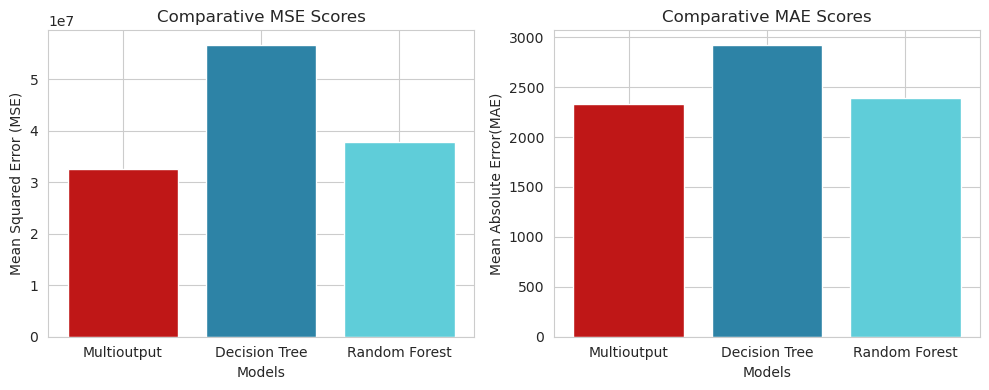

In [297]:
# Create a comparative visualization
plt.figure(figsize=(10, 4))
models = ['Multioutput', 'Decision Tree', 'Random Forest']
mse_scores = [multioutput_mse, tree_mse, forest_mse]
mae_scores = [multioutput_mae, tree_mae, forest_mae]
 
# Plot Mean Squared Error (MSE)
plt.subplot(1, 2, 1)
plt.bar(models, mse_scores, color=['#BF1717', '#2D83A6', '#5FCDD9'])
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparative MSE Scores')

# Plot R-squared Score (R2)
plt.subplot(1, 2, 2)
plt.bar(models, mae_scores, color=['#BF1717', '#2D83A6', '#5FCDD9'])
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error(MAE)')
plt.title('Comparative MAE Scores')

plt.tight_layout()
plt.show()

Multiouput model performed bets out of the 3 compared

## Polynomial

### Testing one Pair at a Time

#### Scool-Funding vs. Child Poverty

In [298]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
# converting x to numpy array, then reshaping to 2D to use in PolynomialFeatures
X_vector = X.to_numpy()
#X_reshaped = X_vector.reshape(-1, 1)

In [299]:
poly_features = poly.fit_transform(X_vector)
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)
y_predicted = poly_reg_model.predict(poly_features)

In [300]:
print(poly_reg_model.intercept_)
print(poly_reg_model.coef_)
print(poly_reg_model.score(poly_features, y))

[-3.01793042e-01 -5.97650829e-01  1.90280438e+05  9.06034944e+01
 -5.21111671e+03]
[[-8.38092519e-06  1.55401310e-01  4.01317590e-11  6.02253681e-07
  -1.06134091e-02]
 [-3.07263385e-05  5.45571930e+00 -4.27340563e-09 -1.29866799e-04
  -3.81674097e-01]
 [ 1.73537205e+00 -4.24172987e+04  9.59718454e-06 -1.44672027e-01
   3.34234066e+03]
 [ 2.70827467e-04 -5.21462779e+00  3.14309467e-09 -2.88785849e-06
   3.83504273e-01]
 [-2.24343657e-01  4.93204191e+03 -1.85037334e-06 -5.26342021e-03
  -3.28943644e+02]]
0.4588594744953567


### Polynomial Regression with Multiple Features

#### Both x variables vs. Child Poverty 

In [301]:
X, y = x, agg_select_subset['child_poverty_percentage']
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=42)
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)

LinearRegression()

In [302]:
poly_reg_y_predicted = poly_reg_model.predict(X_test)
from sklearn.metrics import mean_squared_error
poly_reg_rmse = np.sqrt(mean_squared_error(y_test, poly_reg_y_predicted))
poly_reg_rmse

np.float64(0.049268825227077505)

##### Comparing Performance of Polynomial Model vs. Linear Model 

In [303]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
lin_reg_y_predicted = lin_reg_model.predict(X_test)
lin_reg_rmse = np.sqrt(mean_squared_error(y_test, lin_reg_y_predicted))
lin_reg_rmse

np.float64(0.050144733380418915)

RMSE for Polynomial Regression is lower, making it a better model 

In [304]:
print(poly_reg_model.intercept_)
print(poly_reg_model.coef_)

-0.3425557834995204
[-5.72366516e-06  1.73367469e-01  5.18166343e-11  3.14341991e-08
 -1.26050427e-02]


# Group Observations

## Defining Groups

In [305]:
grouped_df = agg_select_subset.copy()
# adding column with inequality quantile 
grouped_df['quartile_income_inequality'] = pd.qcut(grouped_df['income_inequality'], q=4, labels=False)
# adding column defining whether county meets federal school funding requirements
grouped_df['meeting_school_funding_requirement'] = np.where(grouped_df['school_funding_gap']>=0, 'yes', 'no')
school_funding_grouped = grouped_df.groupby('meeting_school_funding_requirement')
income_inequality_grouped = grouped_df.groupby('quartile_income_inequality')

### Descriptive Stats Accross Groups

In [ ]:
school_funding_grouped.describe().round(2)

In [ ]:
income_inequality_grouped.describe().round(2)

## Overview: Grouped Pair Plots

### Distributions: School Funding

In [ ]:
sns.displot(grouped_df, x='child_poverty_percentage', hue='meeting_school_funding_requirement', kind='kde', fill=True, palette='icefire')

sns.displot(grouped_df, x='firearm_fatalities', hue='meeting_school_funding_requirement', kind='kde', fill=True, palette='icefire')

sns.displot(grouped_df, x='median_income', hue='meeting_school_funding_requirement', kind='kde', fill=True, palette='icefire')

sns.displot(grouped_df, x='life_expectancy', hue='meeting_school_funding_requirement', kind='kde', fill=True, palette='icefire')

sns.displot(grouped_df, x='premature_death', hue='meeting_school_funding_requirement', kind='kde', fill=True, palette='icefire')

sns.pairplot(grouped_df, kind='kde', hue='meeting_school_funding_requirement', palette='icefire')

### Across Schools Meeting Federal School Funding Requirements per pupil and those failing to meet them 

In [307]:
group_palette = {'yes': '#2D83A6', 'no': '#401616', 1:'#2D83A6' , 0: '#5FCDD9', 2: '#BF1717',  3: '#401616'}

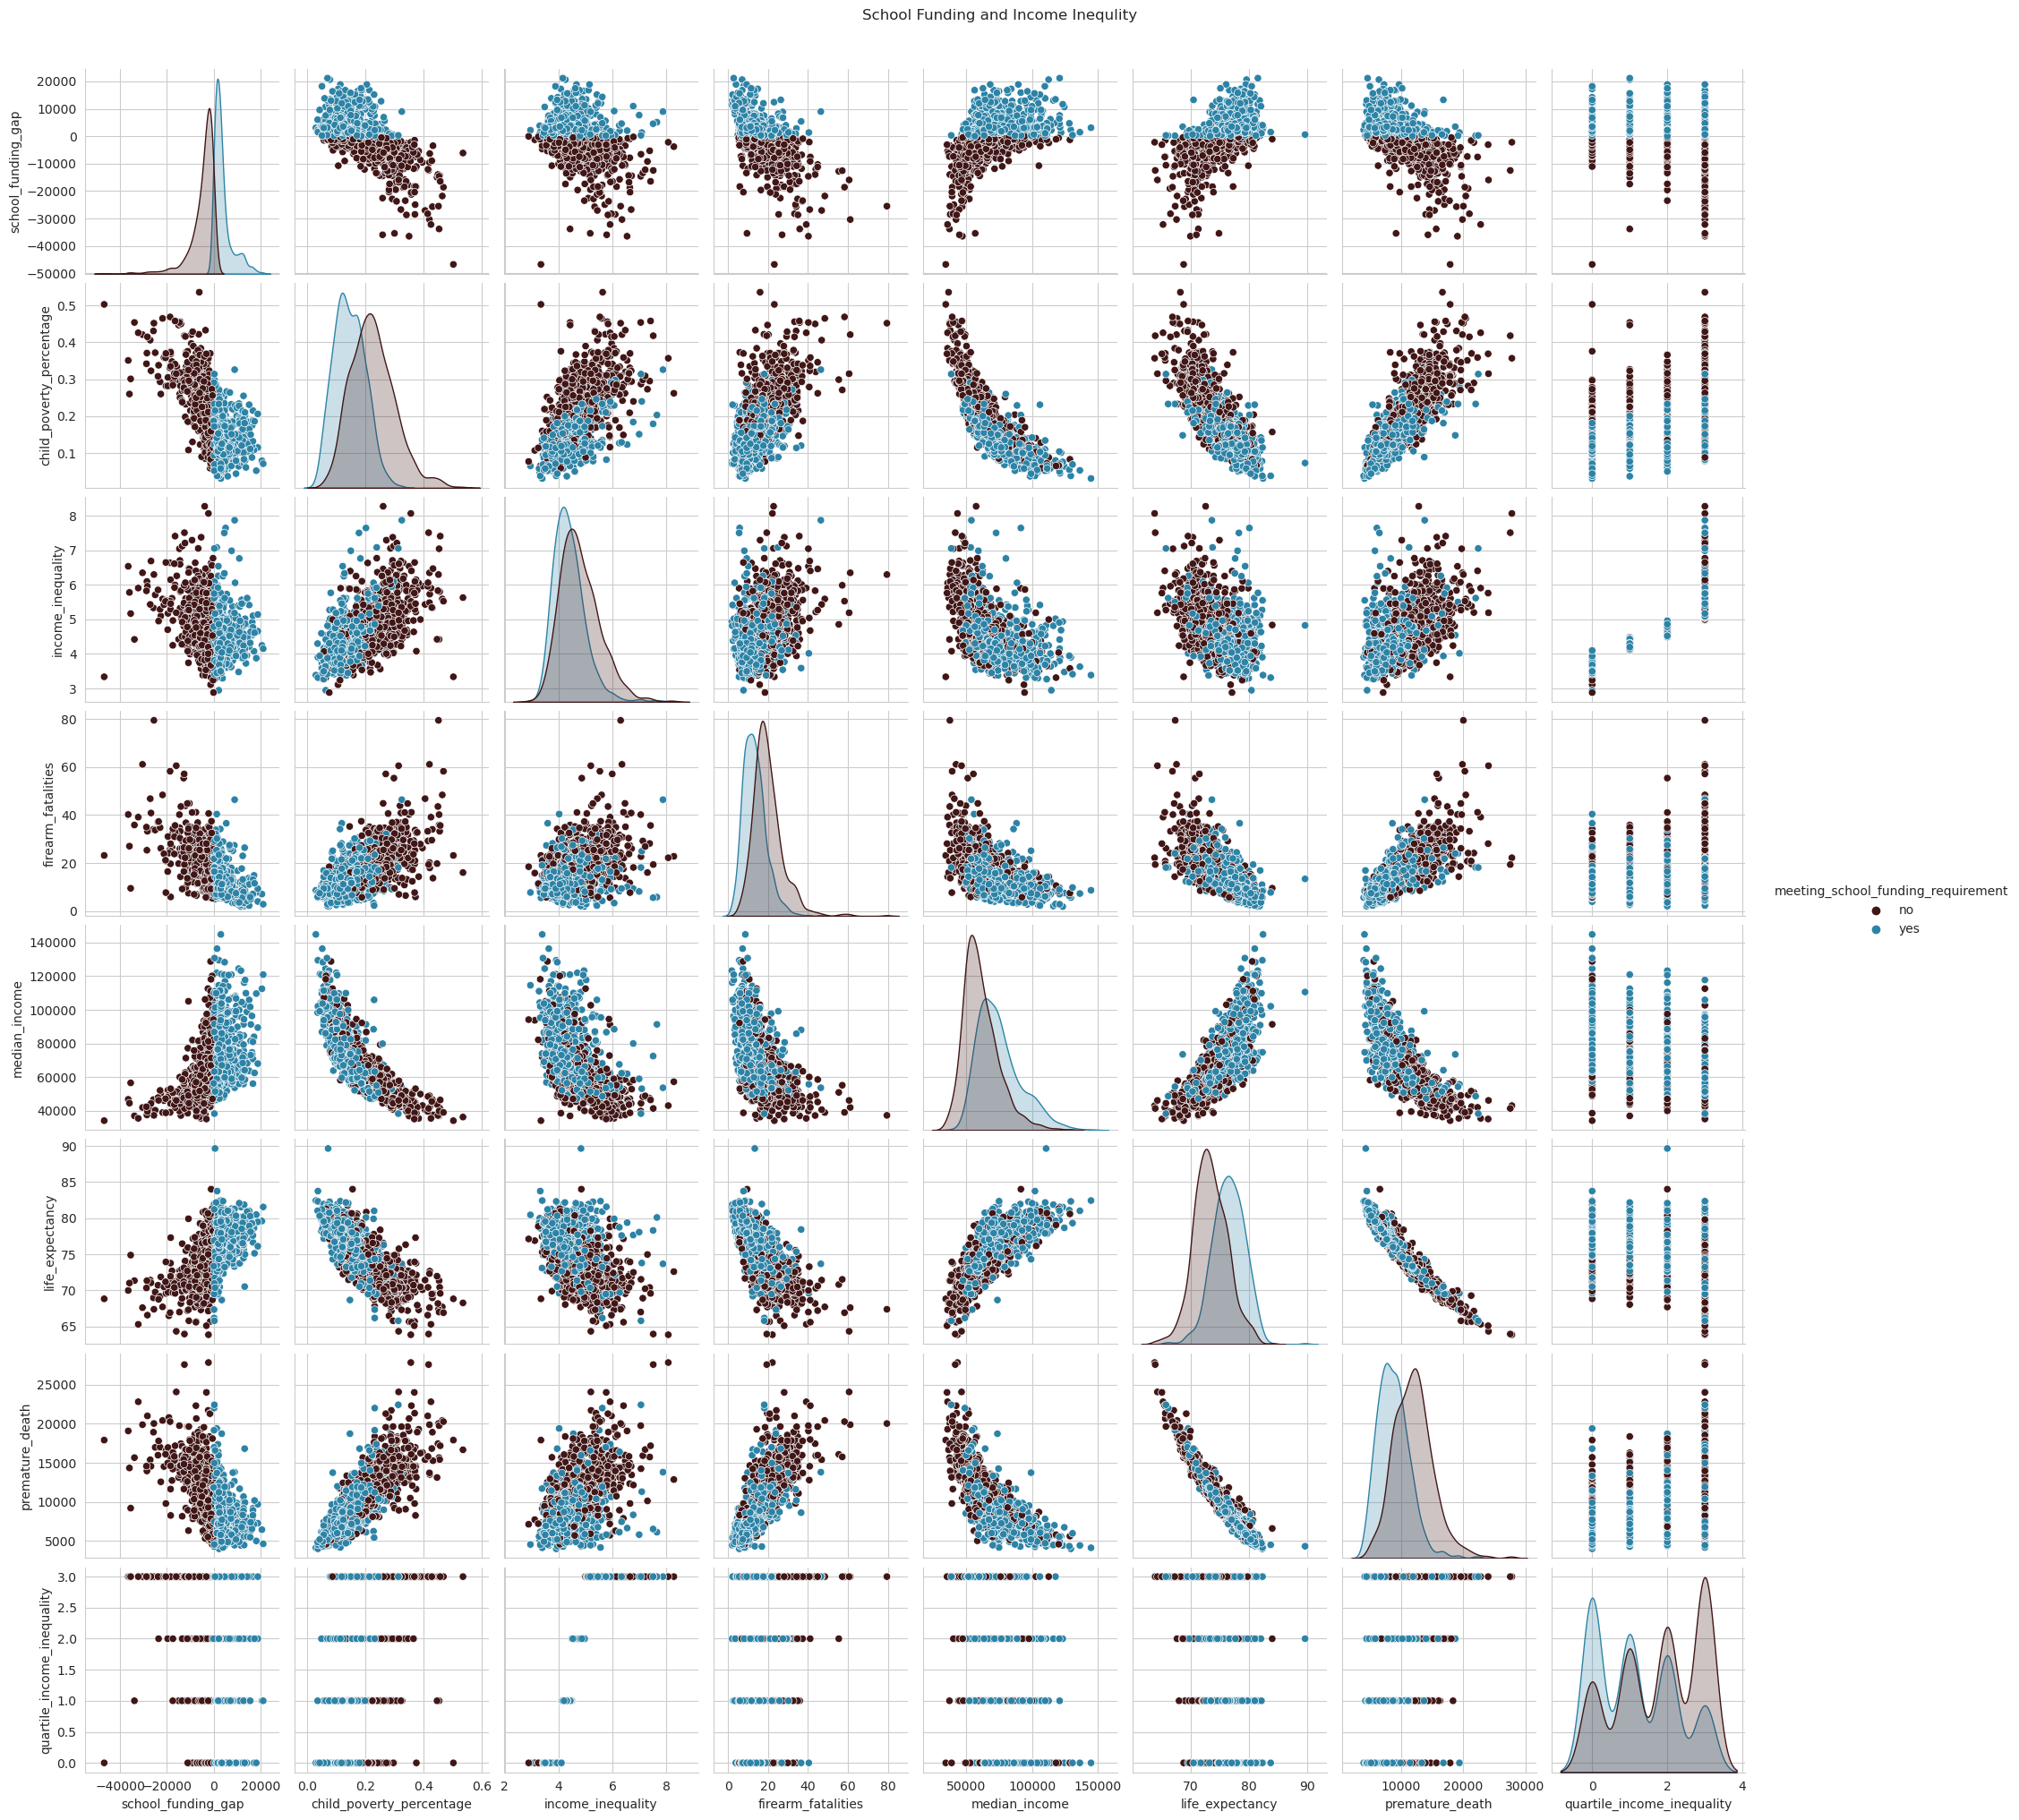

In [308]:
sns.pairplot(grouped_df, hue='meeting_school_funding_requirement', palette=group_palette)
plt.suptitle('School Funding and Income Inequlity', y=1.02)
plt.show()

### Across Quartiles of Income Inequality 

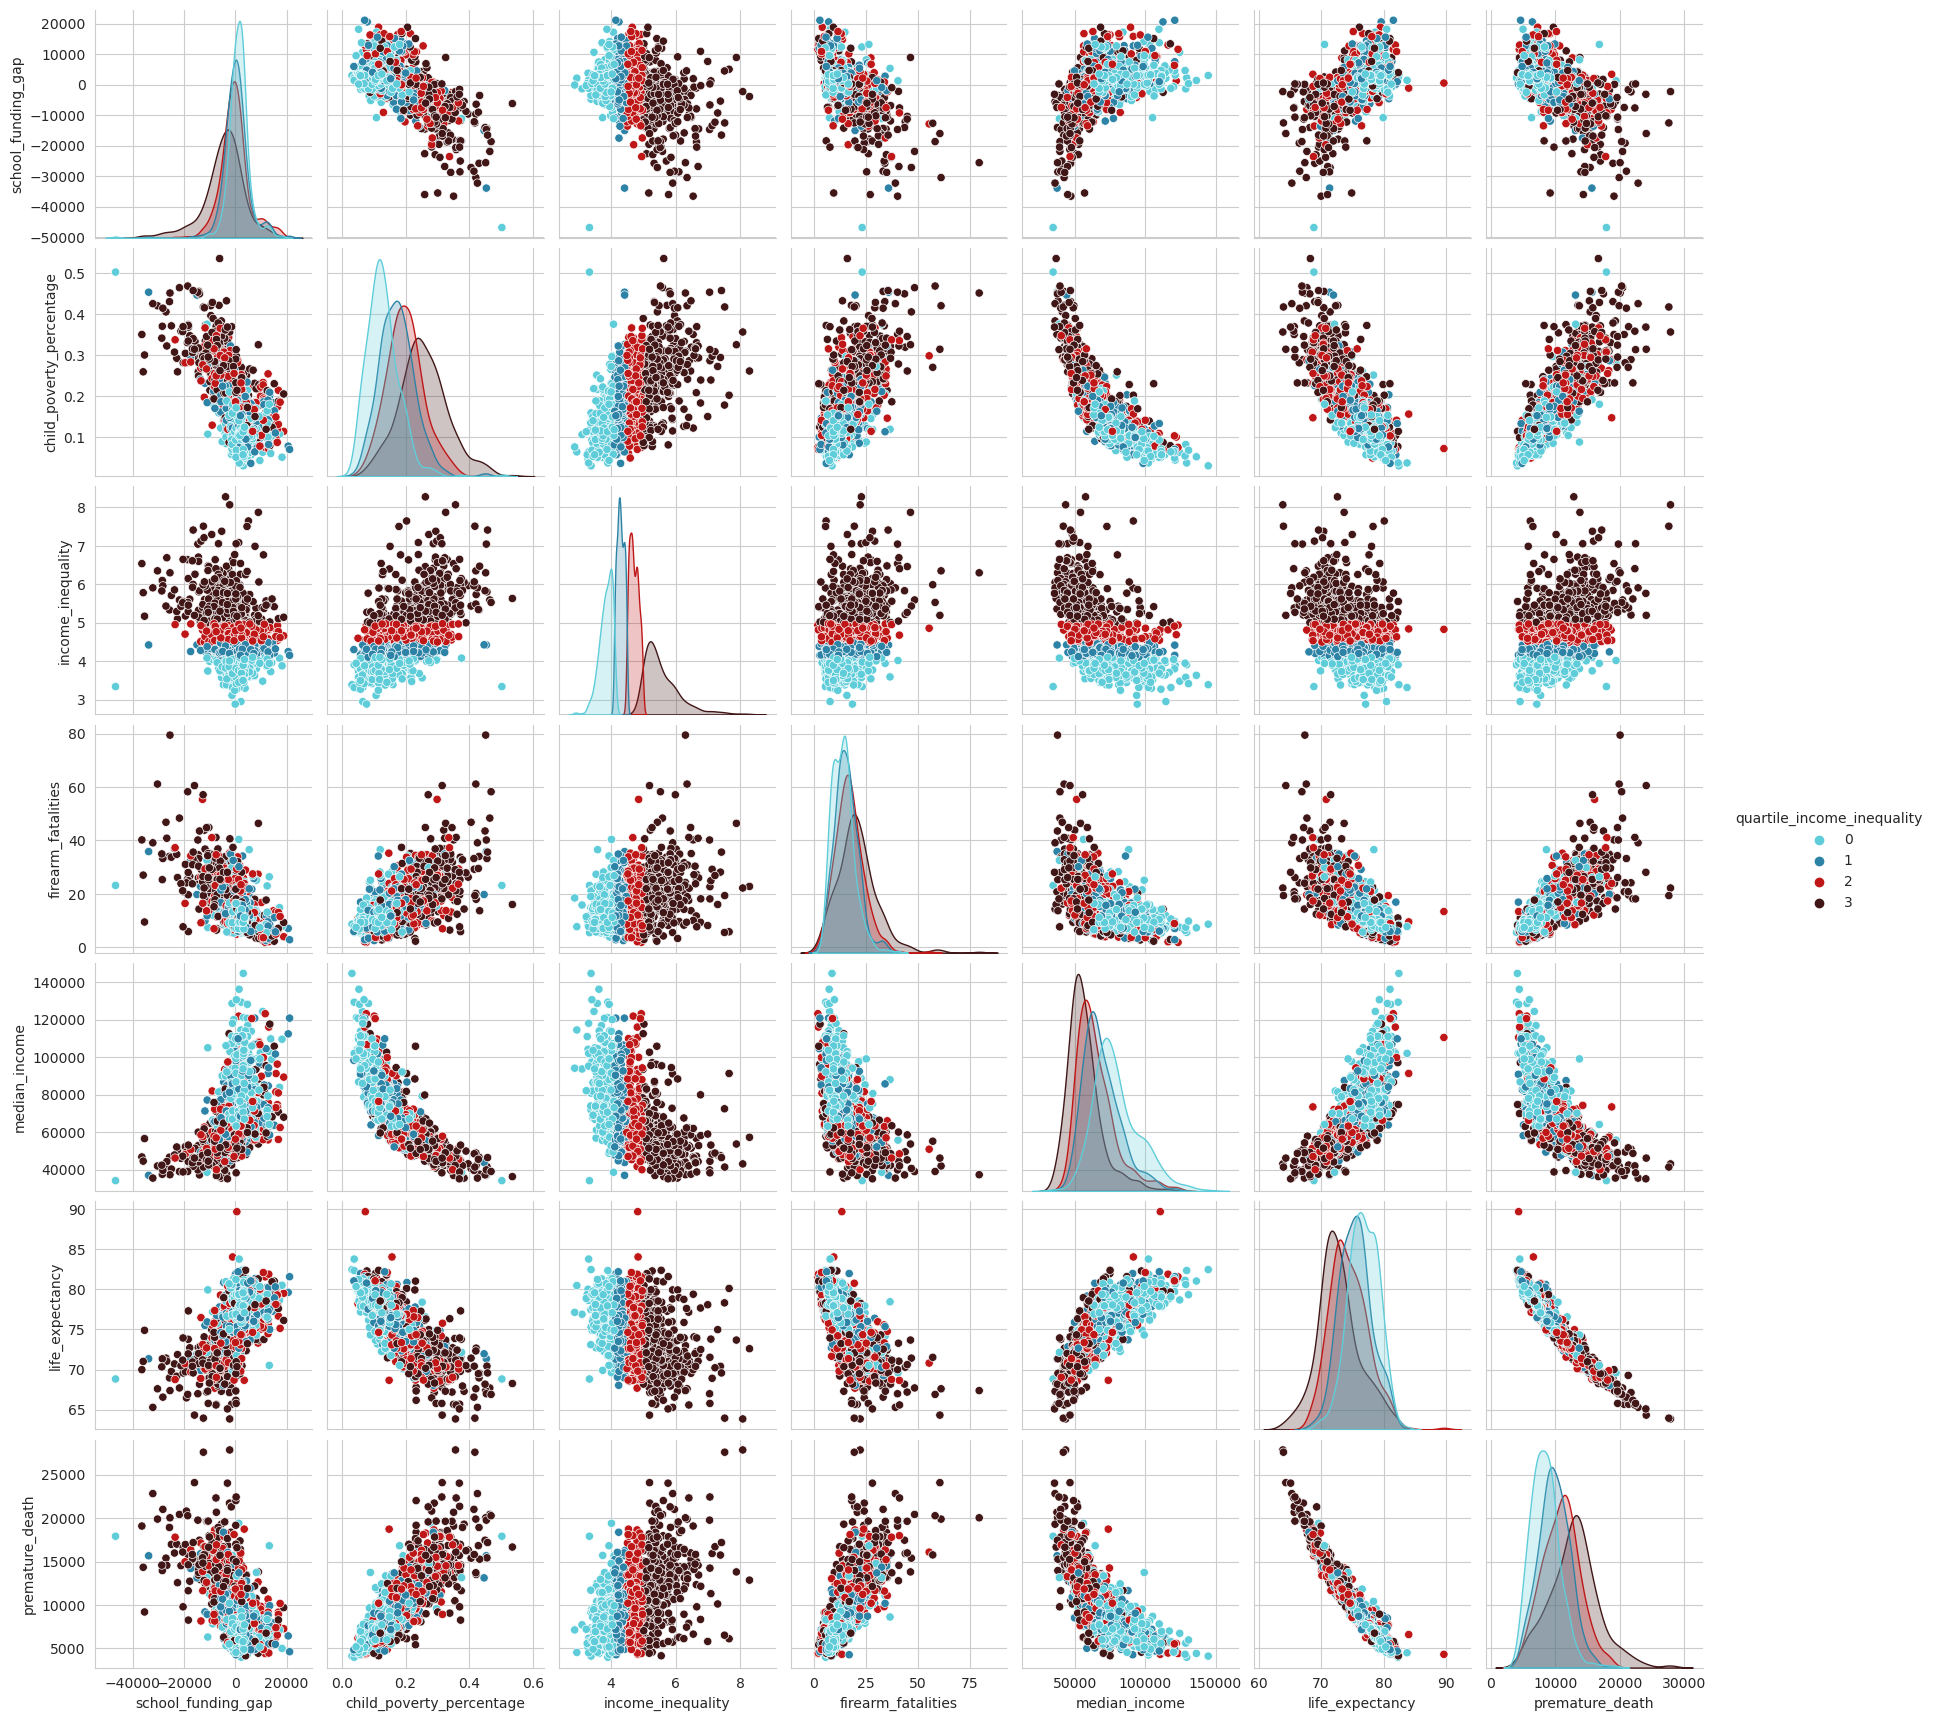

In [309]:
sns.pairplot(grouped_df, hue='quartile_income_inequality', palette=group_palette)
plt.show()

# Chi-Squared Testing

### School Funding

### Income  Inequality

### Political Party

# Conclusion